
# Neural ODE on a 2D Spiral Trajectory (RK4 Solver)

This notebook accompanies Section~\ref{sec:NeuralODE} of the *Mathematics of Generative AI*
living book.

We illustrate a simple **Neural ODE** on a 2D spiral trajectory and save figures into
a local `figs/` directory.


In [1]:

import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

os.makedirs("figs", exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

torch.manual_seed(0)
np.random.seed(0)


Using device: cpu


In [2]:

# Spiral parameters and time grid
alpha_true = 0.3
omega_true = 2.0

T_final = 5.0
N_steps = 200
t_grid = torch.linspace(0.0, T_final, N_steps + 1)

def true_spiral(t, alpha=alpha_true, omega=omega_true):
    r = torch.exp(-alpha * t)
    return torch.stack([r * torch.cos(omega * t),
                        r * torch.sin(omega * t)], dim=-1)

with torch.no_grad():
    x_true = true_spiral(t_grid)

noise_std = 0.03
x_noisy = x_true + noise_std * torch.randn_like(x_true)

print("t_grid shape:", t_grid.shape)
print("x_true shape:", x_true.shape)


t_grid shape: torch.Size([201])
x_true shape: torch.Size([201, 2])


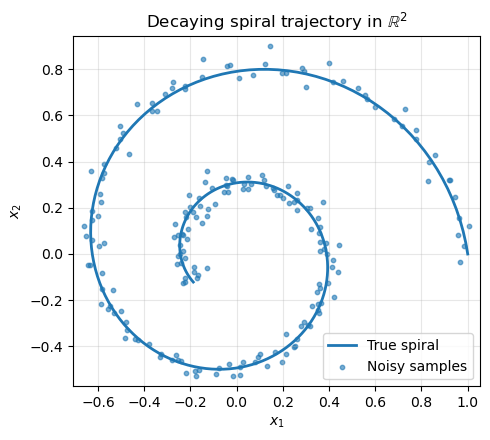

In [3]:

plt.figure(figsize=(5, 4.5))
plt.plot(x_true[:, 0], x_true[:, 1], label="True spiral", linewidth=2)
plt.scatter(x_noisy[:, 0], x_noisy[:, 1], s=10, alpha=0.6, label="Noisy samples")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title("Decaying spiral trajectory in $\mathbb{R}^2$")
plt.legend()
plt.axis("equal")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("figs/neuralode_spiral_data.png", dpi=300, bbox_inches="tight")
plt.show()


In [4]:

class NeuralDrift(nn.Module):
    def __init__(self, dim=2, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, dim),
        )

    def forward(self, x):
        return self.net(x)


def rk4_step(f, x, t, h):
    k1 = f(x, t)
    k2 = f(x + 0.5 * h * k1, t + 0.5 * h)
    k3 = f(x + 0.5 * h * k2, t + 0.5 * h)
    k4 = f(x + h * k3, t + h)
    return x + (h / 6.0) * (k1 + 2.0 * k2 + 2.0 * k3 + k4)


def odeint_rk4(f, x0, t_grid):
    x = x0
    traj = [x0]
    for i in range(len(t_grid) - 1):
        t = t_grid[i]
        h = t_grid[i + 1] - t_grid[i]
        x = rk4_step(f, x, t, h)
        traj.append(x)
    return torch.stack(traj, dim=0)


Iter    1/400: loss = 0.600353
Iter   50/400: loss = 0.080363
Iter  100/400: loss = 0.004461
Iter  150/400: loss = 0.001479
Iter  200/400: loss = 0.001157
Iter  250/400: loss = 0.001041
Iter  300/400: loss = 0.000979
Iter  350/400: loss = 0.000943
Iter  400/400: loss = 0.000921


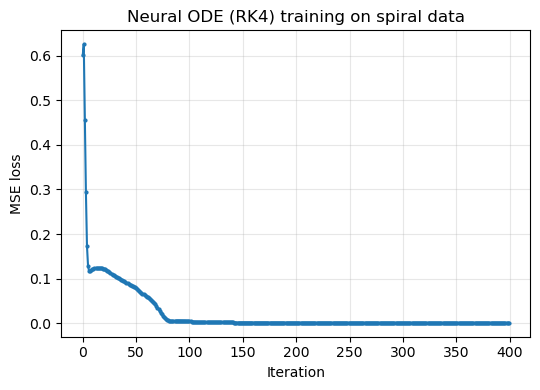

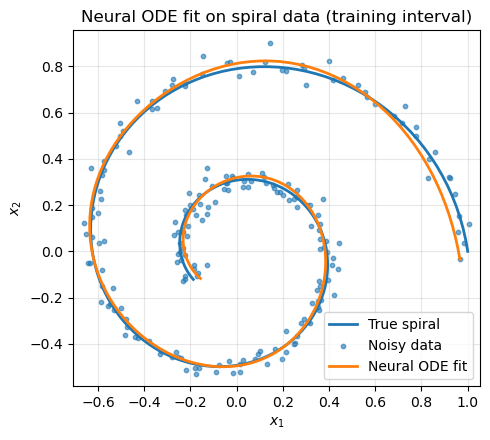

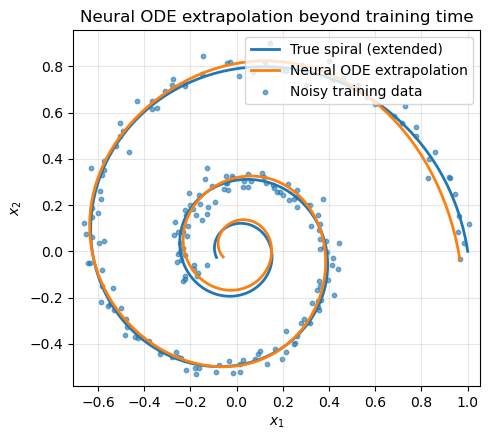

In [5]:

drift = NeuralDrift(dim=2, hidden_dim=64).to(device)

t_grid_dev = t_grid.to(device)
x0 = x_noisy[0].to(device)
x_noisy_dev = x_noisy.to(device)

optimizer = optim.Adam(drift.parameters(), lr=1e-2)
n_iters = 400

loss_history = []

for it in range(1, n_iters + 1):
    optimizer.zero_grad()

    def f(x, t):
        return drift(x)

    x_pred = odeint_rk4(f, x0, t_grid_dev)
    loss = torch.mean((x_pred - x_noisy_dev.to(device))**2)

    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())
    if it % 50 == 0 or it == 1:
        print(f"Iter {it:4d}/{n_iters}: loss = {loss.item():.6f}")

plt.figure(figsize=(5.5, 4))
plt.plot(loss_history, marker="o", markersize=2)
plt.xlabel("Iteration")
plt.ylabel("MSE loss")
plt.title("Neural ODE (RK4) training on spiral data")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("figs/neuralode_spiral_train_curves.png", dpi=300, bbox_inches="tight")
plt.show()

drift.eval()
with torch.no_grad():
    def f_trained(x, t):
        return drift(x)
    x_fit = odeint_rk4(f_trained, x0, t_grid_dev).cpu()

plt.figure(figsize=(5, 4.5))
plt.plot(x_true[:, 0], x_true[:, 1], label="True spiral", linewidth=2)
plt.scatter(x_noisy[:, 0], x_noisy[:, 1], s=10, alpha=0.6, label="Noisy data")
plt.plot(x_fit[:, 0], x_fit[:, 1], label="Neural ODE fit", linewidth=2)
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title("Neural ODE fit on spiral data (training interval)")
plt.legend()
plt.axis("equal")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("figs/neuralode_spiral_fit.png", dpi=300, bbox_inches="tight")
plt.show()

T_ext = 8.0
N_ext = 320
t_grid_ext = torch.linspace(0.0, T_ext, N_ext + 1).to(device)

with torch.no_grad():
    x_fit_ext = odeint_rk4(f_trained, x0, t_grid_ext).cpu()
    x_true_ext = true_spiral(torch.linspace(0.0, T_ext, N_ext + 1))

plt.figure(figsize=(5, 4.5))
plt.plot(x_true_ext[:, 0], x_true_ext[:, 1], label="True spiral (extended)", linewidth=2)
plt.plot(x_fit_ext[:, 0], x_fit_ext[:, 1], label="Neural ODE extrapolation", linewidth=2)
plt.scatter(x_noisy[:, 0], x_noisy[:, 1], s=10, alpha=0.6, label="Noisy training data")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title("Neural ODE extrapolation beyond training time")
plt.legend()
plt.axis("equal")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("figs/neuralode_spiral_extrapolation.png", dpi=300, bbox_inches="tight")
plt.show()
